### Optogenetics 

This notebook has a demo to control an LED for optogenetic control of neural activity. The purpose is to demonstrate how to generate and deliver different light waveforms.

**Regardless of the opsin, different waveforms can have very different impact on neurons activity.** It is important to always check what a specific stimulation pattern is doing to neural activity using electrophysiology. Perhaps the best example is rebound spiking when releasing from a square pulse with an opsin.

Examples:
   * *Control of behavior with optogenetics* - see *video 8* of [Guo et al. 2015](https://elifesciences.org/articles/10774) - "Prehension progression is blocked by optogenetic inhibition of contralateral sensorimotor cortex during Lift."
   * *Record from specific neuron subpopulations* - see figure 3 from [Li et al. 2016](https://www.nature.com/articles/nature14178/figures/3) - "Cell-type-specific electrophysiology"
   * *Probe the impact of activity on perceptual decision making* - see figure 5 of [Odoemene et al. 2018 ](https://www.jneurosci.org/content/38/47/10143/tab-figures-data)
   * *Spatial control of inhibition with light* - see Figure 8 of [Li et al. 2019](https://elifesciences.org/articles/48622) - "Summary of spatial resolution for all photoinhibition methods".

This is the last step of an optogenetics experiment, one first needs to carefully express the virus in the population of interest and find a way to get light to the neurons.

There are also efforts to use this to [restore vision](https://www.youtube.com/watch?v=uEAszLzpjec) and other clinical applications.


###### Equipment:

   * board to generate waveforms and control the amplitude
   * LED controller
   * fiber coupled LED
   * fiber 
   

In [6]:
import numpy as np
import pylab as plt
plt.matplotlib.style.use('ggplot')
%matplotlib inline 

from labdaq import TriggeredOptogeneticsWaveform

task = TriggeredOptogeneticsWaveform(device='dev2',
                                            waveform_channel=0,
                                    trigger_channel='PFI1')
def plot_task_waveform(task):
    ''' This is an auxiliary function to plot the current waveform that is loaded to a task'''
    plt.plot(np.arange(len(task.waveform))/task.sampling_rate, 
             task.waveform,color='#2167ff')
    plt.xlabel('time (s)')
    plt.ylabel('Command amplitude (V)')
    

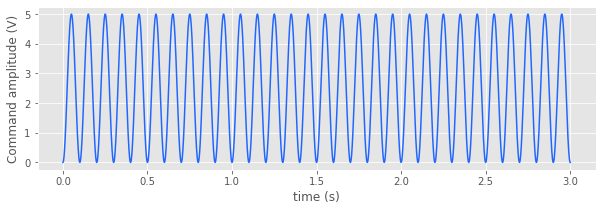

In [35]:
# Stimulate with a raised sine wave
task.generate_waveform(generator = 'sqsine',
                       frequency = 10,
                       amplitude = 5,
                       duration = 3,
                       post_ramp = 0)
task.load(); task.start()


plt.figure(figsize = (10,3))
plot_task_waveform(task);

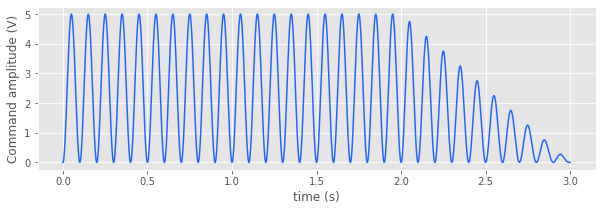

In [37]:
# Stimulate with a raised sine wave with a ramp to prevent rebound from hyperpolarization
task.generate_waveform(generator = 'sqsine',
                       frequency = 10,
                       amplitude = 5,
                       duration = 3,
                       post_ramp = 1)
task.load(); task.start()


plt.figure(figsize = (10,3))
plot_task_waveform(task);

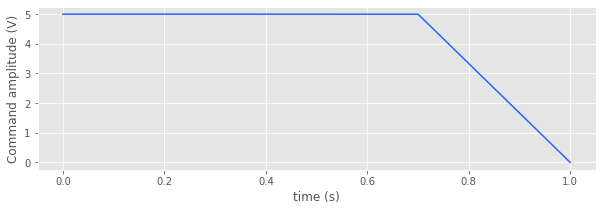

In [38]:
# Stimulate with pulse wave with a ramp to prevent rebound from hyperpolarization
task.generate_waveform(generator = 'pulse',
                       frequency = 10,
                       amplitude = 5,
                       duration = 1,
                       post_ramp = 0.3)
task.load(); task.start()


plt.figure(figsize = (10,3))
plot_task_waveform(task);

In [ ]:
# Triggered stimulation
task.generate_waveform(generator = 'sqsine',
                       frequency = 10,
                       amplitude = 5,
                       duration = 3,
                       post_ramp = 1)
task.load(trigger='PFI1',trigger_retriggerable=False);
task.start()


plt.figure(figsize = (10,3))
plot_task_waveform(task);